Read and fit interaction data from folder ```../data/interaction```

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Read data
background_db = pd.read_csv("../data/interaction/interaction_background.txt", sep=" ", header=None)
addition_db = pd.read_csv("../data/interaction/interaction_addition.txt", sep=" ", header=None)
genus_list = pd.read_csv("../data/interaction/interaction_genus.txt", sep=" ", header=None)

print(background_db.shape, addition_db.shape)
# Initialize list to store changes
change_list = []

# Process each row in addition_db
for i in range(len(addition_db)):
    # Create temporary dataframe
    tmp_change = pd.DataFrame({
        'before': background_db.iloc[i].values,  # Get values as 1D array
        'after': addition_db.iloc[i].values      # Get values as 1D array
    })
    
    # Fit linear regression
    X = tmp_change['before'].values.reshape(-1, 1)
    y = tmp_change['after'].values.reshape(-1, 1)
    lm_model = LinearRegression()
    lm_model.fit(X, y)
    
    # Calculate predictions and confidence intervals
    predictions = lm_model.predict(X).flatten()  # Flatten to 1D
    
    # Calculate prediction intervals (using 99.99% confidence)
    MSE = np.sum((y.flatten() - predictions) ** 2) / (len(y) - 2)
    std_error = np.sqrt(MSE * (1 + 1/len(y) + (X.flatten() - np.mean(X)) ** 2 / np.sum((X.flatten() - np.mean(X)) ** 2)))
    z_value = stats.norm.ppf(0.99995)  # For 99.99% confidence
    
    # Calculate bounds
    lower_bound = predictions - z_value * std_error
    upper_bound = predictions + z_value * std_error
    
    # Add to dataframe
    tmp_change['genus'] = genus_list[0]
    tmp_change['fit'] = predictions
    tmp_change['lwr'] = lower_bound
    tmp_change['upr'] = upper_bound
    tmp_change['residual'] = tmp_change['after'] - tmp_change['fit']
    tmp_change['z_score'] = (tmp_change['residual'] - tmp_change['residual'].mean()) / tmp_change['residual'].std()
    tmp_change['outlier'] = np.where((tmp_change['after'] < lower_bound) | 
                                   (tmp_change['after'] > upper_bound), 
                                   'Outlier', 'Not Outlier')
    tmp_change['add_genus'] = genus_list.iloc[i, 0]
    
    change_list.append(tmp_change)

# Combine all results
change_df = pd.concat(change_list, ignore_index=True)

# Remove lines where genus equals add_genus
change_df1 = change_df[change_df['genus'] != change_df['add_genus']]
change_df1

(1017, 1017) (1017, 1017)


before      after         genus        fit        lwr        upr  \
1         3.139418   3.682535  Abildgaardia   3.296662  -1.466730   8.060054   
2        16.149742  17.703543         Abrus  16.529556  11.767035  21.292078   
3        13.132749  15.459450      Abutilon  13.460950   8.698542  18.223359   
4        53.834606  55.438477      Acalypha  54.859104  50.079160  59.639047   
5         3.111825   4.012928       Acmella   3.268597  -1.494801   8.031994   
...            ...        ...           ...        ...        ...        ...   
1034283  14.635144  15.251649    Xerosicyos  15.478357   9.963905  20.992808   
1034284   7.695374   7.992361         Xylia   7.943144   2.428501  13.457788   
1034285   3.542498   4.227480    Xylocarpus   3.433944  -2.081426   8.949315   
1034286   8.200496   7.940279    Xyloolaena   8.491606   2.977019  14.006192   
1034287   3.476913   3.922122        Zaleya   3.362733  -2.152653   8.878118   

         residual   z_score      outlier    add_genus  
1        0.385874  0.315545  Not Outlier  Abelmoschus  
2        1.173986  0.960018  Not Outlier  Abelmoschus  
3        1.998499  1.634257  Not Outlier  Abelmoschus  
4        0.579373  0.473778  Not Outlier  Abelmoschus  
5        0.744331  0.608671  Not Outlier  Abelmoschus  
...           ...       ...          ...          ...  
1034283 -0.226708 -0.160108  Not Outlier     Ziziphus  
1034284  0.049217  0.034758  Not Outlier     Ziziphus  
1034285  0.793536  0.560420  Not Outlier     Ziziphus  
1034286 -0.551327 -0.389364  Not Outlier     Ziziphus  
1034287  0.559390  0.395058  Not Outlier     Ziziphus  

[1033272 rows x 10 columns]

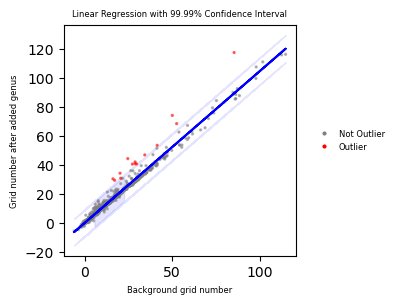

In [2]:
# Create plot for specific genus
def plot_genus_data(change_df1, genus_name):
    # Filter data for specific genus
    plot_data = change_df1[change_df1['add_genus'] == genus_name]
    
    # Create plot
    plt.figure(figsize=(3, 3))
    
    # Plot regression line
    plt.plot(plot_data['before'], plot_data['fit'], color='blue')
    
    # Plot confidence interval
    plt.fill_between(plot_data['before'], 
                    plot_data['lwr'].squeeze(), 
                    plot_data['upr'].squeeze(), 
                    color='blue', alpha=0.1)
    
    # Plot points
    colors = ['grey' if x == 'Not Outlier' else 'red' for x in plot_data['outlier']]
    plt.scatter(plot_data['before'], plot_data['after'], 
               c=colors, alpha=0.5, s=2)
    
    # Customize plot
    plt.title('Linear Regression with 99.99% Confidence Interval', 
             fontsize=6)
    plt.xlabel('Background grid number', fontsize=6)
    plt.ylabel('Grid number after added genus', fontsize=6)
    
    # Customize theme
    plt.grid(False)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='grey', label='Not Outlier', 
                            markersize=4),
                      Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', label='Outlier', 
                            markersize=4)]
    
    # Changed legend position to right side
    plt.legend(handles=legend_elements, 
              bbox_to_anchor=(1.05, 0.5),  
              loc='center left',          
              ncol=1,                      
              fontsize=6, 
              frameon=False)
    
    return plt.gcf()

plot = plot_genus_data(change_df1, "Abildgaardia")

get plots for statistics

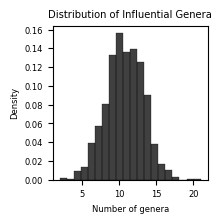

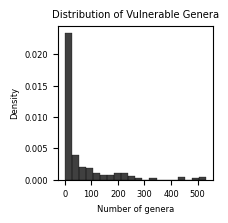

In [3]:
plt.rcParams.update({'font.size': 6})
# Get outliers and frequency counts
outlier_df_9999 = change_df1[change_df1['outlier'] == 'Outlier']
outlier_df_9999_simple = outlier_df_9999[['genus', 'add_genus', 'z_score']]

# Get frequency counts for add_genus
add_genus_freq = pd.DataFrame(outlier_df_9999['add_genus'].value_counts()).reset_index()
add_genus_freq.columns = ['Var1', 'Freq']

# Get frequency counts for impacted genus
impact_genus_freq = pd.DataFrame(outlier_df_9999['genus'].value_counts()).reset_index()
impact_genus_freq.columns = ['Var1', 'Freq']

# Plot 1: Histogram and density plot for influential genera
plt.figure(figsize=(2, 2))
sns.histplot(data=add_genus_freq, x='Freq', stat='density', 
             color='black', edgecolor='black', bins=20, linewidth=0.2)
# sns.kdeplot(data=add_genus_freq, x='Freq', 
#             color='black', fill=True, alpha=0.6)
plt.xlabel('Number of genera', fontsize = 6)
plt.ylabel('Density', fontsize = 6)
plt.grid(False)
plt.title('Distribution of Influential Genera')
plt.show()

# Plot 2: Histogram and density plot for vulnerable genera
plt.figure(figsize=(2, 2))
sns.histplot(data=impact_genus_freq, x='Freq', stat='density', 
             color='black', edgecolor='black', bins=20, linewidth=0.2)
# sns.kdeplot(data=impact_genus_freq, x='Freq', 
#             color='black', fill=True, alpha=0.6)
plt.xlabel('Number of genera', fontsize = 6)
plt.ylabel('Density', fontsize = 6)
plt.grid(False)
plt.title('Distribution of Vulnerable Genera')
plt.show()
